***

# Image Based Recommendations
### - dataset : [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations)
### - method : VGG embedding
### - feature : \[image\] product image

***

## 0) Import library

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.models as models
import torch.nn as nn
import cv2 as cv
import os
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
pd.options.display.float_format = '{:.4f}'.format

***

## 1) Data processing

### load data

In [3]:
articles = pd.read_csv('data/HnM/articles.csv')
articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Large plastic hair claw.


### remain data which product_type_name = Bag

In [10]:
bag_article_id = articles.loc[articles['product_type_name']=="Bag"]["article_id"]

### define dataset iterator (load image by article_id)

In [4]:
class ImageDataset(IterableDataset):
    def __init__(self, article_ids):
        super().__init__()

        self.num_data = len(article_ids)
        self.data = article_ids

        self.img_dir = "data/HnM/images"
        self.w = 224
        self.h = 224
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return self.num_data

    def __iter__(self):
        for i in range(self.num_data):

            article_id = self.data[i]

            folder = '0' + str(article_id)[:2]
            file = '0' + str(article_id) + '.jpg'
            img_path = os.path.join(self.img_dir, folder, file)

            if not os.path.exists(img_path):
                continue

            bgr = cv.imread(img_path)
            rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
            resizes = cv.resize(rgb, (self.w, self.h), interpolation=cv.INTER_LINEAR)
            normalized = resizes/255.
            normalized = (normalized-self.mean)/self.std

            img = self.transform(normalized)

            yield article_id, img

***

## 2) Modeling

### load pretrained VGG model

In [5]:
vgg = models.vgg16(pretrained=True)
vgg.eval()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### modify last layer from VGG network

In [6]:
class ImageEmbedding:
    def __init__(self, model):
        super().__init__()

        self.model = model
        model.classifier[6] = nn.Identity()

    def embedding(self, rgb):
        embeded = self.model.forward(rgb.float())

        return embeded

### get embeddings

In [11]:
dataset = ImageDataset(article_ids=bag_article_id.to_list())
train_loader = DataLoader(dataset, batch_size=128)

model = ImageEmbedding(vgg)
article_idx = []
embedding_data = None

for batch_idx, samples in tqdm(enumerate(train_loader)):
    article_id, img = samples
    embed = model.embedding(img)

    article_idx += article_id.tolist()
    if embedding_data is None:
        embedding_data = embed.detach().numpy()
    else:
        embedding_data = np.concatenate([embedding_data, embed.detach().numpy()])

10it [05:31, 33.15s/it]


In [12]:
embedding_df = pd.DataFrame(embedding_data, index=article_idx)
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
241436001,0.0000,0.0000,0.0000,0.0000,0.2827,1.4150,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,3.3937,3.9636,0.0000,0.0000,0.0000
241436006,0.0000,0.0000,0.0000,0.0000,0.1583,1.4673,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.1958,5.1609,1.1153,0.0000,0.3214,0.0000
289834016,0.0000,0.0000,0.0000,0.0000,0.0000,0.8363,0.0000,0.0000,0.0000,0.8823,...,0.1325,0.0651,0.0000,0.0000,0.0000,0.0000,0.1226,0.0000,0.0000,0.2344
360295023,0.0000,0.0000,0.0000,0.0000,0.0000,2.4768,0.0000,0.3965,0.0000,0.0000,...,0.3850,0.0000,0.0000,0.0000,0.0000,4.4740,3.9123,0.0000,0.0000,0.0000
380894037,0.0000,0.0000,0.0000,0.0000,0.0000,4.3956,0.0000,0.0000,0.1722,0.0000,...,0.0000,0.0000,0.0000,0.0000,5.1360,3.6469,0.1012,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927684001,0.0000,0.0000,1.8646,0.0000,0.0000,2.5433,0.0000,0.0000,0.0000,0.0000,...,1.3549,0.0000,0.0000,0.1528,0.0000,0.0000,1.8016,0.0000,0.0000,0.0000
929033001,0.0000,0.0000,0.0000,0.0000,0.0000,2.5250,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,2.4880,1.1659,0.0000,0.0000,0.0000
939492001,0.0000,0.0000,0.0000,0.0000,0.2864,1.1325,0.0000,0.2963,0.0000,0.0000,...,2.2600,0.0000,0.0000,0.0000,0.5643,1.5565,2.4780,0.0000,0.5200,0.0000
939501001,0.0000,0.0000,3.2878,0.5961,0.0000,1.7892,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.9359,0.0000,1.9316,1.9009,0.9508,0.0000,0.0000,0.0000


### calculate similarity between product embeddings

In [14]:
similarity = cosine_similarity(embedding_data, embedding_data)
similarity_df = pd.DataFrame(similarity, index=embedding_df.index, columns=embedding_df.index)
similarity_df

,241436001,241436006,289834016,360295023,380894037,382468007,386678001,386678003,386681012,386681013,...,918325001,919553001,919907001,922447001,922451001,927684001,929033001,939492001,939501001,939503001
241436001,1.0000,0.8323,0.4706,0.7444,0.3263,0.2888,0.2814,0.4169,0.4397,0.4144,...,0.5382,0.4878,0.1922,0.4839,0.3481,0.2970,0.3919,0.6596,0.2819,0.4462
241436006,0.8323,1.0000,0.5417,0.6745,0.4029,0.3099,0.2566,0.4936,0.4759,0.5440,...,0.4955,0.4590,0.2818,0.4257,0.3671,0.3073,0.3547,0.6532,0.3204,0.3955
289834016,0.4706,0.5417,1.0000,0.4507,0.3055,0.2290,0.2277,0.2597,0.2965,0.3956,...,0.3595,0.3199,0.2608,0.2848,0.2885,0.3072,0.2540,0.4555,0.3114,0.2777
360295023,0.7444,0.6745,0.4507,1.0000,0.2964,0.2953,0.3263,0.4343,0.4282,0.4380,...,0.6852,0.4785,0.2078,0.6810,0.3760,0.3963,0.4677,0.5955,0.2795,0.4304
380894037,0.3263,0.4029,0.3055,0.2964,1.0000,0.3158,0.3715,0.5796,0.3837,0.5657,...,0.2000,0.2268,0.2854,0.2197,0.3107,0.2067,0.2797,0.3291,0.3317,0.4821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927684001,0.2970,0.3073,0.3072,0.3963,0.2067,0.3773,0.4130,0.3551,0.4355,0.3843,...,0.5275,0.3898,0.3990,0.3839,0.6820,1.0000,0.4013,0.4488,0.5330,0.3876
929033001,0.3919,0.3547,0.2540,0.4677,0.2797,0.2836,0.6168,0.4862,0.4522,0.3929,...,0.4883,0.4154,0.3552,0.5639,0.4460,0.4013,1.0000,0.3967,0.4365,0.5827
939492001,0.6596,0.6532,0.4555,0.5955,0.3291,0.3646,0.3505,0.4933,0.3810,0.4502,...,0.6539,0.5234,0.3054,0.5193,0.5369,0.4488,0.3967,1.0000,0.3610,0.4468
939501001,0.2819,0.3204,0.3114,0.2795,0.3317,0.3502,0.4842,0.3788,0.3883,0.4794,...,0.3127,0.4252,0.5194,0.3247,0.5091,0.5330,0.4365,0.3610,1.0000,0.4250


***

## 3) Recommendation

### define function for recommendation

In [15]:
def get_similar_product(article_id, top_k):
    similarities = similarity_df.loc[article_id][~similarity_df.index.isin([article_id])].sort_values(ascending=False)
    return similarities[:top_k].index

### define function for visualize

In [21]:
def visualize(query_id, reco_list):
    plt.rcParams["figure.figsize"] = [16, 12]
    
    img_dir = "data/HnM/images"
    
    folder = '0' + str(query_id)[:2]
    file = '0' + str(query_id) + '.jpg'
    img_path = os.path.join(img_dir, folder, file)
    bgr = cv.imread(img_path)
    rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
    
    plt.imshow(rgb)
    plt.axis(False)
    plt.title(f"query product image({query_id})", fontsize=20)
    plt.show()
    
    for i in range(len(reco_list)):
        plt.subplot(len(reco)//5, 5,i+1)
        article_id = reco[i]
        folder = '0' + str(article_id)[:2]
        file = '0' + str(article_id) + '.jpg'
        img_path = os.path.join(img_dir, folder, file)
        bgr = cv.imread(img_path)
        rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
        plt.imshow(rgb)
        plt.axis(False)
    
    plt.suptitle(f"similar {len(reco_list)} items", fontsize=20)
    plt.show()
    plt.close()

### example

In [17]:
query_id = 241436001

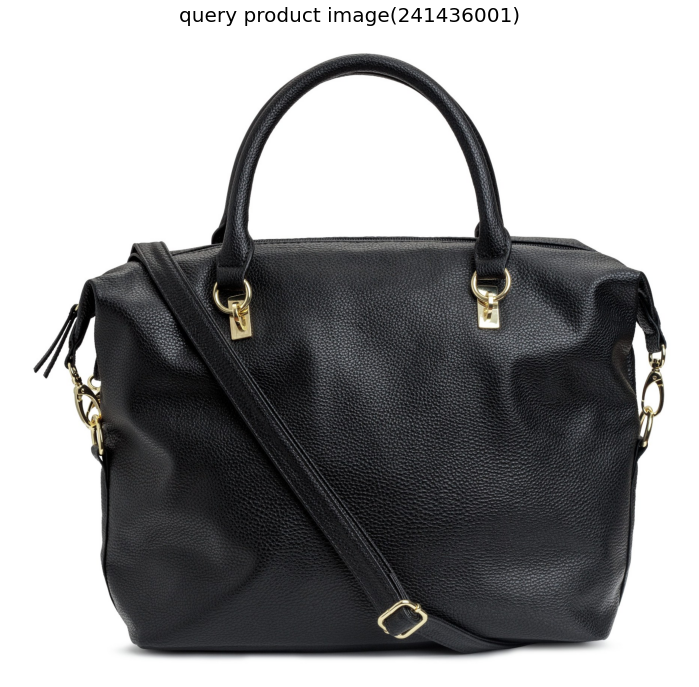

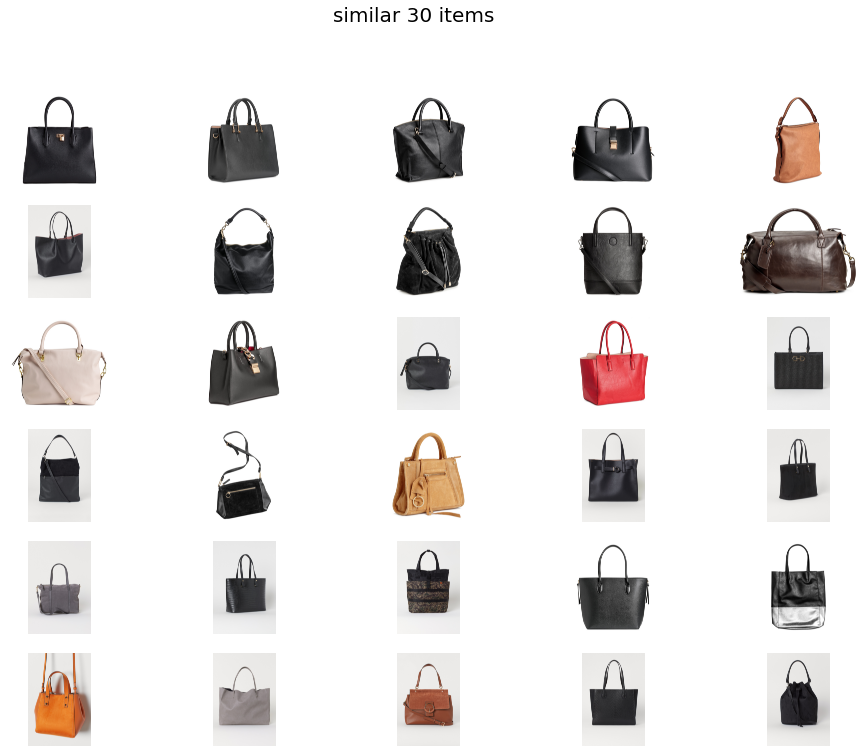

In [22]:
reco = get_similar_product(article_id=query_id, top_k=30)
visualize(query_id, reco)